<a href="https://colab.research.google.com/github/GabrielMartinHsia/ACOEM/blob/main/ACOEM_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook to be used for ACOEM data processing & plotting. Use DB Browser for SQ Lite (portable) to view databases. See ACOEM_Discovery.ipynb for some explanation of the functions below.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sqlite3
import re
import numpy as np
import os
import pandas as pd
from scipy.fft import fft, rfft, fftfreq, rfftfreq
import matplotlib.pyplot as plt

In [3]:
dbfile = '/content/drive/My Drive/Work/Vibration/ForDiscovery/LOCALHOST/RT0.db'
signal = '/content/drive/My Drive/Work/Vibration/ForDiscovery/LOCALHOST/Signals/SG40751_20230323_173539.asp'

# db Functions

In [4]:
#Imprt database at 'db_file' path/name
def importdb(db_file):
  conn = sqlite3.connect(db_file)
  cursor = conn.cursor()
  cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
  for table in cursor.fetchall():
    yield list(cursor.execute('SELECT * from ?;', (table[0],))) #'return' sends a value and terminates the function. 'yield' allows the function to continue.

#SQL fetch SIGNAL table from db file
def fetch_table(db_file, table="SIGNAL", show=False):
  conn = sqlite3.connect(db_file)
  cursor = conn.cursor()
  cursor.execute(f"SELECT * FROM {table}")
  rows = cursor.fetchall()
  column_names = [i[0] for i in cursor.description]

  if show:
    print(column_names)
    for row in rows:
      print(row)

  return pd.DataFrame(rows, columns=column_names)

#Get equipment index
def equipment_index(db_file, signal):
  conn = sqlite3.connect(db_file)
  cursor = conn.cursor()
  signal_ID = signal[signal.rindex('SG')+2:signal.rindex('_')-9]
  cursor.execute(f'select IDX_POINT from SIGNAL where IDX_SIGNAL = {signal_ID}')
  return cursor.fetchall()[0][0]

#Get signal type
def signal_type(db_file, signal):
  conn = sqlite3.connect(db_file)
  cursor = conn.cursor()
  signal_ID = signal[signal.rindex('SG')+2:signal.rindex('_')-9]
  cursor.execute(f'select NAME from SIGNAL where IDX_SIGNAL = {signal_ID}')
  return cursor.fetchall()[0][0]

#get measurement location
def measurement_location(db_file, index):
  conn = sqlite3.connect(db_file)
  cursor = conn.cursor()
  cursor.execute(f'select NAME_ELEMENT from ASSET_HIERARCHY where IDX_ELEMENT={index}')
  measurement_loc = cursor.fetchall()
  measurement_loc = str(*measurement_loc[0])

  cursor.execute(f'select IDX_PARENT_ELEMENT from ASSET_HIERARCHY where IDX_ELEMENT={index}')
  machine_index = cursor.fetchall()
  machine_index = int(*machine_index[0])

  cursor.execute(f'select NAME_ELEMENT from ASSET_HIERARCHY where IDX_ELEMENT={machine_index}')
  parent_machine = cursor.fetchall()

  return f'{parent_machine[0][0]}: {measurement_loc}'

#read contents of binary file
def raw_signal(signal):
  with open(signal, "rb") as f:
    contents = f.read()
    return contents

#find first zero in the unpacked contents of the binary data
def first_zero_index(contents):
  zero_index = list(contents).index(0,0)
  return zero_index

#decode 4-element words
def decimal2base256(four_element_word):
  w = four_element_word[3]
  x = four_element_word[2]
  y = four_element_word[1]
  z = four_element_word[0]
  return w*256**3 + x*256**2 + y*256 + z

#chop header info and return only frequency-spectrum data
def get_channel_data(contents, zero_index):
  raw = list(contents[(zero_index - 4):])
  if len(raw)%8 == 0:
    data = np.array(raw)
    data = data.reshape((len(data)//8, 2, 4))
    d = []
    for n in data:
      data_point = decimal2base256(n[0])
      d.append(data_point/2**32)
  else:
    print("zero index error...")
    exit()
  return d

#generate a signal file path for all signals in the signal table, given a sample signal file path/name
def generate_signal_files(dbfile, sample_signal_file):
  signal_table = fetch_table(dbfile, table="SIGNAL")
  signal_files = []
  for idx_sgnl in signal_table.IDX_SIGNAL:
    signal = sample_signal_file[:sample_signal_file.rindex('SG')+2] + f'{idx_sgnl}' + sample_signal_file[sample_signal_file.rindex('SG')+2+len(f'{idx_sgnl}'):]
    signal_files.append(signal)
  return signal_files, list(signal_table.IDX_SIGNAL)

#generate a dictionary of signal names and signal data... can loop through and overlay signals on single plot.
def signal_data_dict(dbfile, sample_signal_file, show=True):
  '''
  won't work if you don't have all the signal files copied to the drive folder... duh...
  '''
  signal_files, signal_names = generate_signal_files(dbfile, sample_signal_file)

  signal_dict = {}
  for f, name in list(zip(signal_files, signal_names)):
    try:
      raw = raw_signal(f)
      data = get_channel_data(raw, first_zero_index(raw))
      signal_dict[name] = data
    except FileNotFoundError:
      if show:
        print(f'file: {f} ... not found')
      pass

  return signal_dict

In [5]:
# plt.figure(figsize=(10,6))
# plt.plot(Hz, data)
# plt.grid()
# plt.title(f'{measurement_location(dbfile, equipment_index(dbfile, signal))}\n{signal_type(dbfile, signal)}')

# Plotting A Frequency Spectrum

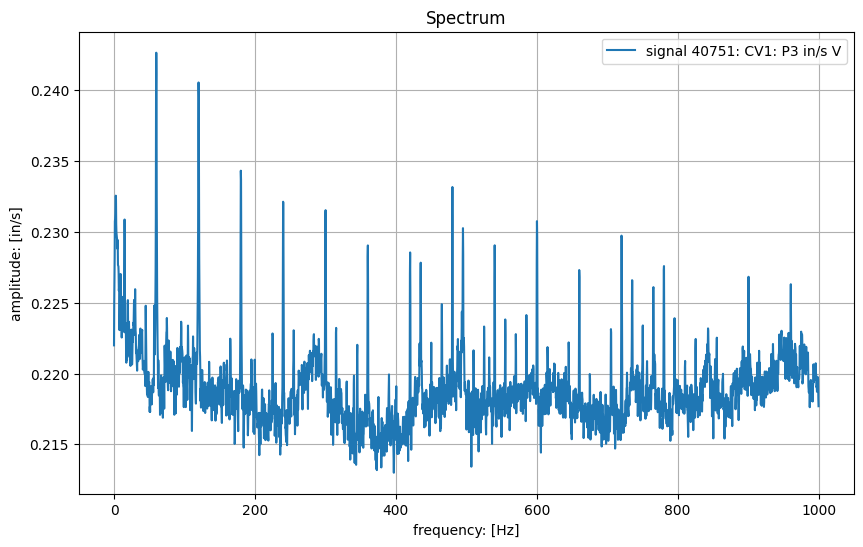

In [6]:
all_signals = signal_data_dict(dbfile, signal, show=False)
dx = 0.3125
x0 = 0

plt.figure(figsize=(10,6))
for name, data in all_signals.items():
  Hz = np.arange(x0, len(data)*dx, dx)
  plt.plot(Hz, data, label=f'signal {name}: {measurement_location(dbfile, equipment_index(dbfile, signal))}') #fix this! 'signal' arg is a const, needs to be updatable in the loop here... idea: update equipment_index() function to take either signal name or signal file name/path


plt.xlabel('frequency: [Hz]')
plt.ylabel('amplitude: [in/s]')
plt.legend()
plt.grid()
plt.title(f'{signal_type(dbfile, signal)}')
plt.show()

In [7]:
fetch_table(dbfile, "ASSET_HIERARCHY")

,IDX_ELEMENT,TYPE_ELEMENT,IDX_PARENT_ELEMENT,LEVEL_NODE,IDX_NODE,IDX_NODE_PARENT,NAME_ELEMENT,ABBREVIATE_ELEMENT,STATUS_ALARM_ELEMENT,COMPLETION_ELEMENT,X_POS_PERCENT,Y_POS_PERCENT,PICTURE_FILE,PICTURE_MODIFIED,INSTRUMENT_MODIFIED
0,0,0,-1,1,1,-1,OFF_ROUTE,OFF_ROUTE,0,1,0.0,0.0,,0,0
1,3041,0,0,2,2,1,OFF_ROUTE,OFF_ROUTE,0,1,0.0,0.0,,0,0
2,8122,1,3041,2,10,2,CV1,-,0,1,0.0,0.0,None,0,1
3,15591,2,8122,3,11,10,P1 in/s Ax,P1 mm/s A,0,0,0.0,0.0,None,0,1
4,15592,2,8122,3,12,10,P2 in/s H,P2 mm/s H,0,2,0.0,0.0,None,0,1
5,15593,2,8122,3,13,10,P3 in/s V,P3 mm/s V,0,2,0.0,0.0,None,0,1
6,15594,2,8122,3,14,10,P4 in/s Ax,P4 in/s A,0,2,0.0,0.0,None,0,1
7,15595,2,8122,3,15,10,P5 in/s H,P5 in/s H,0,0,0.0,0.0,None,0,1
8,15596,2,8122,3,16,10,P6 in/s V,P6 in/s V,0,0,0.0,0.0,None,0,1


# A db Class

In [8]:
class ACOEM_db:
  def __init__(self, path):
    self.path = path
    self.conn = sqlite3.connect(path)
    self.curs = self.conn.cursor()

    self.tables = [a for a in self.curs.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]

  def fetch_table(self, table='SIGNAL', show=False):
    self.curs.execute(f'SELECT * FROM {table}')
    rows = self.curs.fetchall()
    column_names = [i[0] for i in self.curs.description]

    if show:
      print(column_names)
      for row in rows:
        print(row)
    return pd.DataFrame(rows, columns=column_names)

In [9]:
BFP_route_db = '/content/drive/My Drive/Work/Vibration/ACOEM/D7420083172/B1/RT2/RT2.db'
BFP_signals_path = '/content/drive/My Drive/Work/Vibration/ACOEM/D7420083172/B1/RT2/Signals/'
BFP_signals_list = os.listdir(BFP_signals_path)

In [10]:
db = ACOEM_db(BFP_route_db)

In [11]:
db.fetch_table("ASSET_HIERARCHY")

,IDX_ELEMENT,TYPE_ELEMENT,IDX_PARENT_ELEMENT,LEVEL_NODE,IDX_NODE,IDX_NODE_PARENT,NAME_ELEMENT,ABBREVIATE_ELEMENT,STATUS_ALARM_ELEMENT,COMPLETION_ELEMENT,X_POS_PERCENT,Y_POS_PERCENT,PICTURE_FILE,PICTURE_MODIFIED,INSTRUMENT_MODIFIED
0,1,0,-1,1,1,-1,U9 and 10 BFP,U9 and 10 BFP,3,2,0.0,0.0,None,0,0
1,8,0,1,2,2,1,U9 and U10 BFP,,3,2,0.0,0.0,None,0,0
2,12,1,8,3,3,2,KSB Boiler Feed Pump 9A - Accurex,,1,2,0.0,0.0,EQ12,0,0
3,1,2,12,4,4,3,1-MT-Ax,1Ax,1,2,10.0,5.0,None,0,0
4,2,2,12,4,5,3,1-MT-RH,1RH,1,2,10.0,15.0,None,0,0
5,3,2,12,4,6,3,1-MT-RV,1RV,1,2,10.0,25.0,None,0,0
6,4,2,12,4,7,3,2-MT-Ax,2Ax,1,2,20.0,5.0,None,0,0
7,5,2,12,4,8,3,2-MT-RH,2RH,1,2,20.0,15.0,None,0,0
8,6,2,12,4,9,3,2-MT-RV,2RV,1,2,20.0,25.0,None,0,0
9,7,2,12,4,10,3,3-PP-Ax,3Ax,1,2,30.0,5.0,None,0,0


In [12]:
db.fetch_table("SIGNAL")

,IDX_POINT,IDX_SIGNAL,NAME,ABBREVIATE,DIAGNOSIS_NAME,TYPE_SIGNAL,UNIT_SIGNAL,TYPE_INPUT,UNIT_INPUT,SENSITIVITY_SENSOR,REFERENCE_DB,PROPERTY_SIGNAL,ORDER_DISPLAY,INSTRUMENT_MODIFIED,UNIT_TEXT
0,9,3426,Spectrum LF,SIG-0001,SIG-0001,1,0,1,0,100.0,1.000000e-06,"<?xml version=""1.0"" encoding=""utf-16""?><Measur...",0,0,-
1,9,3443,Spectrum MF,SIG-0002,SIG-0002,1,0,1,0,100.0,1.000000e-06,"<?xml version=""1.0"" encoding=""utf-16""?><Measur...",1,0,-
2,9,3444,Time wave,SIG-0004,SIG-0004,4,0,1,0,100.0,1.000000e-06,"<?xml version=""1.0"" encoding=""utf-16""?><Measur...",3,0,-
3,9,3460,Spectrum HF,SIG-0003,SIG-0003,1,0,1,0,100.0,1.000000e-06,"<?xml version=""1.0"" encoding=""utf-16""?><Measur...",2,0,-
4,7,3478,Time wave,SIG-0004,SIG-0004,4,0,1,0,100.0,1.000000e-06,"<?xml version=""1.0"" encoding=""utf-16""?><Measur...",3,0,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,42,4930,Time wave,SIG-0004,SIG-0004,4,0,1,0,100.0,1.000000e-06,"<?xml version=""1.0"" encoding=""utf-16""?><Measur...",3,0,-
188,43,4935,Spectrum LF,SIG-0001,SIG-0001,1,0,1,0,100.0,1.000000e-06,"<?xml version=""1.0"" encoding=""utf-16""?><Measur...",0,0,-
189,43,4936,Spectrum HF,SIG-0003,SIG-0003,1,0,1,0,100.0,1.000000e-06,"<?xml version=""1.0"" encoding=""utf-16""?><Measur...",2,0,-
190,44,4937,Time wave,SIG-0004,SIG-0004,4,0,1,0,100.0,1.000000e-06,"<?xml version=""1.0"" encoding=""utf-16""?><Measur...",3,0,-


In [14]:
BFP_signals_list

['SG4782_20230926_185611.asp',
 'SG4753_20230926_185611.asp',
 'SG4763_20230926_185611.asp',
 'SG4713_20230926_185614.sig',
 'SG4764_20230926_185614.sig',
 'SG4790_20230926_185614.sig',
 'SG4791_20230926_185622.asp',
 'SG4758_20230926_185622.asp',
 'SG4762_20230926_185622.asp',
 'SG4761_20230926_185625.asp',
 'SG4759_20230926_185625.asp',
 'SG4754_20230926_185625.asp',
 'SG4682_20230926_185655.asp',
 'SG4832_20230926_185655.asp',
 'SG4689_20230926_185657.sig',
 'SG4688_20230926_185655.asp',
 'SG4712_20230926_185657.sig',
 'SG4930_20230926_185657.sig',
 'SG4683_20230926_185702.asp',
 'SG4687_20230926_185702.asp',
 'SG4831_20230926_185702.asp',
 'SG4684_20230926_185704.asp',
 'SG4686_20230926_185704.asp',
 'SG4830_20230926_185704.asp',
 'SG4854_20230926_185820.asp',
 'SG4936_20230926_185820.asp',
 'SG4925_20230926_185820.asp',
 'SG4944_20230926_185822.sig',
 'SG4855_20230926_185822.sig',
 'SG4937_20230926_185822.sig',
 'SG4921_20230926_185826.asp',
 'SG4853_20230926_185826.asp',
 'SG4924